# Data - Competition

## Imports e reads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
df_meteo1 = pd.read_csv('datasets/meteo_202109-202112.csv', encoding='latin1')
df_meteo2 = pd.read_csv('datasets/meteo_202201-202212.csv', encoding='latin1')
df_meteo3 = pd.read_csv('datasets/meteo_202301-202304.csv', encoding='latin1')
df_energia1 = pd.read_csv('datasets/energia_202109-202112.csv', encoding='latin1')
df_energia2 = pd.read_csv('datasets/energia_202201-202212.csv', encoding='latin1')
df_energia3 = pd.read_csv('datasets/energia_202301-202304.csv', encoding='latin1') # Temos que prever os valores da energia injetada neste dataset
df_open = pd.read_csv('datasets/open-meteo-41.58N8.44W193m.csv', delimiter=',')
df_submission = pd.read_csv('datasets/dummy_submission.csv')

## Tratamento dos dados

Adicionar a coluna 'Injeção na rede (KWh)' para mais tarde colocar os valores previsto nessa coluna e adicionar aos dummys

In [3]:
df_energia3['Injeção na rede (kWh)'] = np.nan
df_energia3

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2023-01-01,0,0.000,0.467,0.000,NaN
1,2023-01-01,1,0.000,0.577,0.000,NaN
2,2023-01-01,2,0.000,0.346,0.000,NaN
3,2023-01-01,3,0.000,0.270,0.000,NaN
4,2023-01-01,4,0.000,0.252,0.000,NaN
...,...,...,...,...,...,...
2251,2023-04-04,19,0.953,0.000,0.012,NaN
2252,2023-04-04,20,0.915,0.000,0.000,NaN
2253,2023-04-04,21,0.479,0.000,0.000,NaN
2254,2023-04-04,22,0.000,0.497,0.000,NaN


### Tratamento dos dados de 2021

In [4]:
df_energia1.rename(columns={'Data': 'date', 'Hora': 'hour'}, inplace=True)
df_energia1

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.000,0.000,0.0,NaN
1,2021-09-29,1,0.000,0.000,0.0,NaN
2,2021-09-29,2,0.000,0.000,0.0,NaN
3,2021-09-29,3,0.000,0.000,0.0,NaN
4,2021-09-29,4,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...
2251,2021-12-31,19,2.176,0.000,0.0,NaN
2252,2021-12-31,20,0.732,0.000,0.0,NaN
2253,2021-12-31,21,0.704,0.000,0.0,NaN
2254,2021-12-31,22,0.000,0.424,0.0,NaN


In [5]:
df_meteo1

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,1640977200,2021-12-31 19:00:00 +0000 UTC,local,16.72,16.35,16.22,17.79,1024,NaN,NaN,73,3.05,NaN,91,overcast clouds
2924,1640980800,2021-12-31 20:00:00 +0000 UTC,local,16.54,16.10,15.67,17.23,1024,NaN,NaN,71,3.32,NaN,97,overcast clouds
2925,1640984400,2021-12-31 21:00:00 +0000 UTC,local,15.71,15.09,15.66,16.22,1023,NaN,NaN,67,3.43,NaN,94,overcast clouds
2926,1640988000,2021-12-31 22:00:00 +0000 UTC,local,16.59,15.98,16.21,16.72,1024,NaN,NaN,64,3.29,NaN,83,broken clouds


In [6]:
# Converter a coluna 'dt_iso' para datetime
df_meteo1['dt_iso'] = pd.to_datetime(df_meteo1['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')

# Criar novas colunas 'date' e 'hour'
df_meteo1['date'] = df_meteo1['dt_iso'].dt.strftime('%Y-%m-%d')
df_meteo1['hour'] = df_meteo1['dt_iso'].dt.hour

# Reordenar as colunas
df_meteo1 = df_meteo1[['date', 'hour'] + [col for col in df_meteo1.columns if col not in ['dt_iso', 'date', 'hour']]]

# Exibir o DataFrame resultante
df_meteo1

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2021-09-01,0,1630454400,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,2021-09-01,1,1630458000,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,2021-09-01,2,1630461600,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,2021-09-01,3,1630465200,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,2021-09-01,4,1630468800,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2021-12-31,19,1640977200,local,16.72,16.35,16.22,17.79,1024,NaN,NaN,73,3.05,NaN,91,overcast clouds
2924,2021-12-31,20,1640980800,local,16.54,16.10,15.67,17.23,1024,NaN,NaN,71,3.32,NaN,97,overcast clouds
2925,2021-12-31,21,1640984400,local,15.71,15.09,15.66,16.22,1023,NaN,NaN,67,3.43,NaN,94,overcast clouds
2926,2021-12-31,22,1640988000,local,16.59,15.98,16.21,16.72,1024,NaN,NaN,64,3.29,NaN,83,broken clouds


In [7]:
# Supondo que 'date' e 'hour' sejam colunas em ambos os DataFrames
df1 = pd.merge(df_meteo1, df_energia1, on=['date', 'hour'], how='inner')

# Exibir o DataFrame resultante
df1

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,local,13.97,13.54,11.45,14.04,1027,NaN,NaN,81,1.96,NaN,87,overcast clouds,0.000,0.000,0.0,NaN
1,2021-09-29,1,1632877200,local,13.48,13.02,13.43,13.90,1028,NaN,NaN,82,1.83,NaN,91,overcast clouds,0.000,0.000,0.0,NaN
2,2021-09-29,2,1632880800,local,12.93,12.47,12.72,13.43,1027,NaN,NaN,84,1.96,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
3,2021-09-29,3,1632884400,local,12.61,12.15,10.34,12.93,1027,NaN,NaN,85,1.85,NaN,95,overcast clouds,0.000,0.000,0.0,NaN
4,2021-09-29,4,1632888000,local,12.61,12.17,9.79,12.93,1027,NaN,NaN,86,1.83,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2021-12-31,19,1640977200,local,16.72,16.35,16.22,17.79,1024,NaN,NaN,73,3.05,NaN,91,overcast clouds,2.176,0.000,0.0,NaN
2252,2021-12-31,20,1640980800,local,16.54,16.10,15.67,17.23,1024,NaN,NaN,71,3.32,NaN,97,overcast clouds,0.732,0.000,0.0,NaN
2253,2021-12-31,21,1640984400,local,15.71,15.09,15.66,16.22,1023,NaN,NaN,67,3.43,NaN,94,overcast clouds,0.704,0.000,0.0,NaN
2254,2021-12-31,22,1640988000,local,16.59,15.98,16.21,16.72,1024,NaN,NaN,64,3.29,NaN,83,broken clouds,0.000,0.424,0.0,NaN


<Axes: >

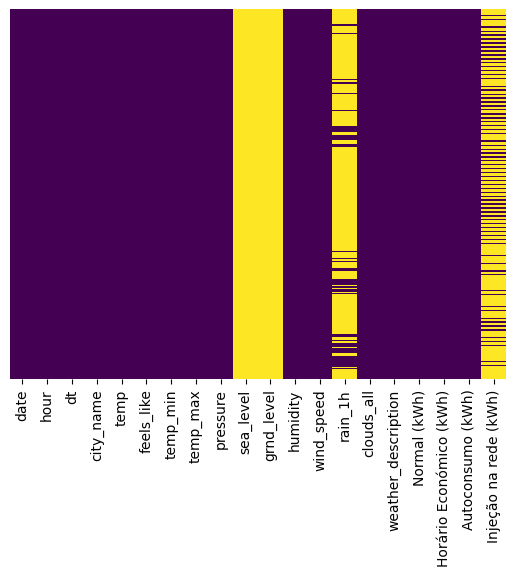

In [8]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     2256 non-null   object 
 1   hour                     2256 non-null   int32  
 2   dt                       2256 non-null   int64  
 3   city_name                2256 non-null   object 
 4   temp                     2256 non-null   float64
 5   feels_like               2256 non-null   float64
 6   temp_min                 2256 non-null   float64
 7   temp_max                 2256 non-null   float64
 8   pressure                 2256 non-null   int64  
 9   sea_level                0 non-null      float64
 10  grnd_level               0 non-null      float64
 11  humidity                 2256 non-null   int64  
 12  wind_speed               2256 non-null   float64
 13  rain_1h                  386 non-null    float64
 14  clouds_all              

In [10]:
df1 = df1.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)
df1

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,NaN,87,overcast clouds,0.000,0.000,0.0,NaN
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,NaN,91,overcast clouds,0.000,0.000,0.0,NaN
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,NaN,95,overcast clouds,0.000,0.000,0.0,NaN
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,NaN,93,overcast clouds,0.000,0.000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2021-12-31,19,1640977200,16.72,16.35,16.22,17.79,1024,73,3.05,NaN,91,overcast clouds,2.176,0.000,0.0,NaN
2252,2021-12-31,20,1640980800,16.54,16.10,15.67,17.23,1024,71,3.32,NaN,97,overcast clouds,0.732,0.000,0.0,NaN
2253,2021-12-31,21,1640984400,15.71,15.09,15.66,16.22,1023,67,3.43,NaN,94,overcast clouds,0.704,0.000,0.0,NaN
2254,2021-12-31,22,1640988000,16.59,15.98,16.21,16.72,1024,64,3.29,NaN,83,broken clouds,0.000,0.424,0.0,NaN


In [11]:
# Contagem de valores nulos em cada coluna
print(df1.isnull().sum())

date                          0
hour                          0
dt                            0
temp                          0
feels_like                    0
temp_min                      0
temp_max                      0
pressure                      0
humidity                      0
wind_speed                    0
rain_1h                    1870
clouds_all                    0
weather_description           0
Normal (kWh)                  0
Horário Económico (kWh)       0
Autoconsumo (kWh)             0
Injeção na rede (kWh)      1690
dtype: int64


In [12]:
# Contagem de valores únicos em cada coluna
print(df1.nunique())

date                         94
hour                         24
dt                         2256
temp                       1023
feels_like                 1214
temp_min                    245
temp_max                    229
pressure                     35
humidity                     68
wind_speed                  554
rain_1h                     149
clouds_all                  101
weather_description           8
Normal (kWh)                772
Horário Económico (kWh)     329
Autoconsumo (kWh)           440
Injeção na rede (kWh)         4
dtype: int64


In [13]:
# Verificar a presença de valores NaN no DataFrame
print(df1.isna().values.any())

True


In [14]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')

In [15]:
df1['Injeção na rede (kWh)'].replace({None: 'None', np.nan: 'None'}, inplace=True)
df1['rain_1h'].fillna(0, inplace=True)
df1

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,overcast clouds,0.000,0.000,0.0,None
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,overcast clouds,0.000,0.000,0.0,None
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,overcast clouds,0.000,0.000,0.0,None
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,overcast clouds,0.000,0.000,0.0,None
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,overcast clouds,0.000,0.000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2021-12-31,19,1640977200,16.72,16.35,16.22,17.79,1024,73,3.05,0.0,91,overcast clouds,2.176,0.000,0.0,None
2252,2021-12-31,20,1640980800,16.54,16.10,15.67,17.23,1024,71,3.32,0.0,97,overcast clouds,0.732,0.000,0.0,None
2253,2021-12-31,21,1640984400,15.71,15.09,15.66,16.22,1023,67,3.43,0.0,94,overcast clouds,0.704,0.000,0.0,None
2254,2021-12-31,22,1640988000,16.59,15.98,16.21,16.72,1024,64,3.29,0.0,83,broken clouds,0.000,0.424,0.0,None


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     2256 non-null   datetime64[ns]
 1   hour                     2256 non-null   int32         
 2   dt                       2256 non-null   int64         
 3   temp                     2256 non-null   float64       
 4   feels_like               2256 non-null   float64       
 5   temp_min                 2256 non-null   float64       
 6   temp_max                 2256 non-null   float64       
 7   pressure                 2256 non-null   int64         
 8   humidity                 2256 non-null   int64         
 9   wind_speed               2256 non-null   float64       
 10  rain_1h                  2256 non-null   float64       
 11  clouds_all               2256 non-null   int64         
 12  weather_description      2256 non-

<Axes: >

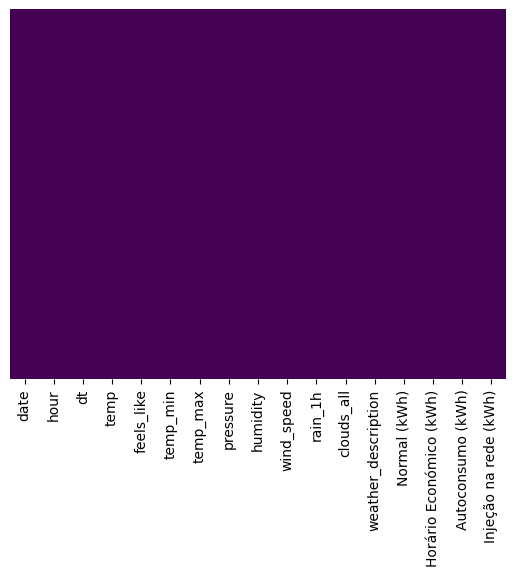

In [17]:
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Tratamento dos dados de 2022

In [18]:
df_energia2.rename(columns={'Data': 'date', 'Hora': 'hour'}, inplace=True)
df_energia2

,date,hour,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,0.000,0.486,0.0,NaN
1,2022-01-01,1,0.000,0.429,0.0,NaN
2,2022-01-01,2,0.000,0.463,0.0,NaN
3,2022-01-01,3,0.000,0.545,0.0,NaN
4,2022-01-01,4,0.000,0.439,0.0,NaN
...,...,...,...,...,...,...
8755,2022-12-31,19,1.693,0.000,0.0,NaN
8756,2022-12-31,20,1.327,0.000,0.0,NaN
8757,2022-12-31,21,0.757,0.000,0.0,NaN
8758,2022-12-31,22,0.000,0.675,0.0,NaN


In [19]:
df_meteo2

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1640995200,2022-01-01 00:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds
1,1640998800,2022-01-01 01:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds
2,1641002400,2022-01-01 02:00:00 +0000 UTC,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds
3,1641006000,2022-01-01 03:00:00 +0000 UTC,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds
4,1641009600,2022-01-01 04:00:00 +0000 UTC,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1672513200,2022-12-31 19:00:00 +0000 UTC,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
8756,1672516800,2022-12-31 20:00:00 +0000 UTC,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
8757,1672520400,2022-12-31 21:00:00 +0000 UTC,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
8758,1672524000,2022-12-31 22:00:00 +0000 UTC,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [20]:
# Converter a coluna 'dt_iso' para datetime
df_meteo2['dt_iso'] = pd.to_datetime(df_meteo2['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')

# Criar novas colunas 'date' e 'hour'
df_meteo2['date'] = df_meteo2['dt_iso'].dt.strftime('%Y-%m-%d')
df_meteo2['hour'] = df_meteo2['dt_iso'].dt.hour

# Reordenar as colunas
df_meteo2 = df_meteo2[['date', 'hour'] + [col for col in df_meteo2.columns if col not in ['dt_iso', 'date', 'hour']]]

# Exibir o DataFrame resultante
df_meteo2

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,2022-01-01,0,1640995200,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds
1,2022-01-01,1,1640998800,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds
2,2022-01-01,2,1641002400,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds
3,2022-01-01,3,1641006000,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds
4,2022-01-01,4,1641009600,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain
8756,2022-12-31,20,1672516800,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain
8757,2022-12-31,21,1672520400,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain
8758,2022-12-31,22,1672524000,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain


In [21]:
# Supondo que 'date' e 'hour' sejam colunas em ambos os DataFrames
df2 = pd.merge(df_meteo2, df_energia2, on=['date', 'hour'], how='inner')

# Exibir o DataFrame resultante
df2

,date,hour,dt,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,1640995200,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds,0.000,0.486,0.0,NaN
1,2022-01-01,1,1640998800,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds,0.000,0.429,0.0,NaN
2,2022-01-01,2,1641002400,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds,0.000,0.463,0.0,NaN
3,2022-01-01,3,1641006000,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds,0.000,0.545,0.0,NaN
4,2022-01-01,4,1641009600,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds,0.000,0.439,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,local,15.70,15.57,15.57,15.72,1018,NaN,NaN,86,5.56,3.58,100,moderate rain,1.693,0.000,0.0,NaN
8756,2022-12-31,20,1672516800,local,15.55,15.43,12.72,15.70,1018,NaN,NaN,87,4.47,4.20,100,heavy intensity rain,1.327,0.000,0.0,NaN
8757,2022-12-31,21,1672520400,local,13.45,13.28,12.23,13.99,1019,NaN,NaN,93,3.29,4.23,100,heavy intensity rain,0.757,0.000,0.0,NaN
8758,2022-12-31,22,1672524000,local,12.93,12.73,12.23,13.43,1019,NaN,NaN,94,1.49,3.90,100,moderate rain,0.000,0.675,0.0,NaN


<Axes: >

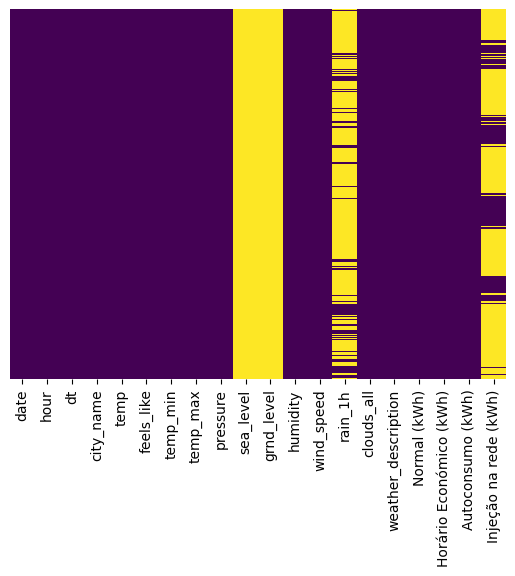

In [22]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     8760 non-null   object 
 1   hour                     8760 non-null   int32  
 2   dt                       8760 non-null   int64  
 3   city_name                8760 non-null   object 
 4   temp                     8760 non-null   float64
 5   feels_like               8760 non-null   float64
 6   temp_min                 8760 non-null   float64
 7   temp_max                 8760 non-null   float64
 8   pressure                 8760 non-null   int64  
 9   sea_level                0 non-null      float64
 10  grnd_level               0 non-null      float64
 11  humidity                 8760 non-null   int64  
 12  wind_speed               8760 non-null   float64
 13  rain_1h                  1898 non-null   float64
 14  clouds_all              

In [24]:
df2 = df2.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)
df2

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,1640995200,16.59,16.00,16.21,16.72,1024,65,3.15,NaN,97,overcast clouds,0.000,0.486,0.0,NaN
1,2022-01-01,1,1640998800,16.59,16.00,16.21,16.72,1024,65,3.14,NaN,58,broken clouds,0.000,0.429,0.0,NaN
2,2022-01-01,2,1641002400,16.59,16.03,15.67,16.72,1024,66,3.12,NaN,23,few clouds,0.000,0.463,0.0,NaN
3,2022-01-01,3,1641006000,13.59,12.75,11.61,16.16,1023,67,3.08,NaN,22,few clouds,0.000,0.545,0.0,NaN
4,2022-01-01,4,1641009600,14.97,14.27,14.72,15.66,1023,67,3.12,NaN,15,few clouds,0.000,0.439,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,moderate rain,1.693,0.000,0.0,NaN
8756,2022-12-31,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,heavy intensity rain,1.327,0.000,0.0,NaN
8757,2022-12-31,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,heavy intensity rain,0.757,0.000,0.0,NaN
8758,2022-12-31,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,moderate rain,0.000,0.675,0.0,NaN


In [25]:
# Contagem de valores nulos em cada coluna
print(df2.isnull().sum())

date                          0
hour                          0
dt                            0
temp                          0
feels_like                    0
temp_min                      0
temp_max                      0
pressure                      0
humidity                      0
wind_speed                    0
rain_1h                    6862
clouds_all                    0
weather_description           0
Normal (kWh)                  0
Horário Económico (kWh)       0
Autoconsumo (kWh)             0
Injeção na rede (kWh)      6087
dtype: int64


In [26]:
# Contagem de valores únicos em cada coluna
print(df2.nunique())

date                        365
hour                         24
dt                         8760
temp                       2277
feels_like                 2585
temp_min                    424
temp_max                    511
pressure                     41
humidity                     82
wind_speed                  761
rain_1h                     347
clouds_all                  101
weather_description           8
Normal (kWh)               1132
Horário Económico (kWh)     789
Autoconsumo (kWh)           712
Injeção na rede (kWh)         4
dtype: int64


In [27]:
# Verificar a presença de valores NaN no DataFrame
print(df2.isna().values.any())

True


In [28]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

In [29]:
df2['Injeção na rede (kWh)'].replace({None: 'None', np.nan: 'None'}, inplace=True)
df2['rain_1h'].fillna(0, inplace=True)
df2

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,1640995200,16.59,16.00,16.21,16.72,1024,65,3.15,0.00,97,overcast clouds,0.000,0.486,0.0,None
1,2022-01-01,1,1640998800,16.59,16.00,16.21,16.72,1024,65,3.14,0.00,58,broken clouds,0.000,0.429,0.0,None
2,2022-01-01,2,1641002400,16.59,16.03,15.67,16.72,1024,66,3.12,0.00,23,few clouds,0.000,0.463,0.0,None
3,2022-01-01,3,1641006000,13.59,12.75,11.61,16.16,1023,67,3.08,0.00,22,few clouds,0.000,0.545,0.0,None
4,2022-01-01,4,1641009600,14.97,14.27,14.72,15.66,1023,67,3.12,0.00,15,few clouds,0.000,0.439,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,moderate rain,1.693,0.000,0.0,None
8756,2022-12-31,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,heavy intensity rain,1.327,0.000,0.0,None
8757,2022-12-31,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,heavy intensity rain,0.757,0.000,0.0,None
8758,2022-12-31,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,moderate rain,0.000,0.675,0.0,None


In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     8760 non-null   datetime64[ns]
 1   hour                     8760 non-null   int32         
 2   dt                       8760 non-null   int64         
 3   temp                     8760 non-null   float64       
 4   feels_like               8760 non-null   float64       
 5   temp_min                 8760 non-null   float64       
 6   temp_max                 8760 non-null   float64       
 7   pressure                 8760 non-null   int64         
 8   humidity                 8760 non-null   int64         
 9   wind_speed               8760 non-null   float64       
 10  rain_1h                  8760 non-null   float64       
 11  clouds_all               8760 non-null   int64         
 12  weather_description      8760 non-

<Axes: >

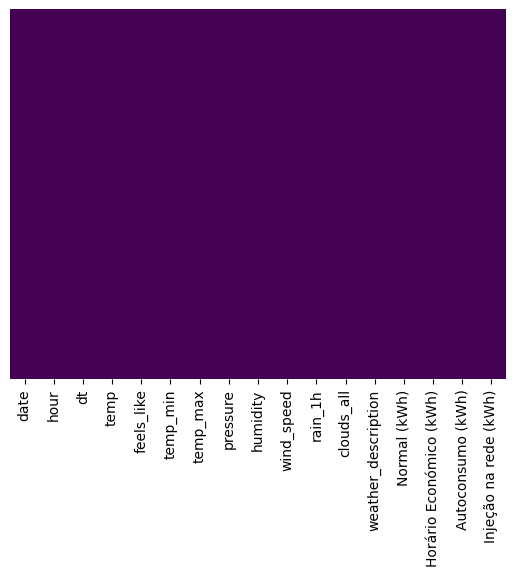

In [31]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Junção dos dataframes de 2021 e 2022

In [32]:
df = pd.concat([df1, df2], ignore_index=True)
df

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,87,overcast clouds,0.000,0.000,0.0,None
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,91,overcast clouds,0.000,0.000,0.0,None
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,93,overcast clouds,0.000,0.000,0.0,None
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,95,overcast clouds,0.000,0.000,0.0,None
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,93,overcast clouds,0.000,0.000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,2022-12-31,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,moderate rain,1.693,0.000,0.0,None
11012,2022-12-31,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,heavy intensity rain,1.327,0.000,0.0,None
11013,2022-12-31,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,heavy intensity rain,0.757,0.000,0.0,None
11014,2022-12-31,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,moderate rain,0.000,0.675,0.0,None


In [33]:
value_counts = df['Injeção na rede (kWh)'].value_counts(dropna=False)
print(value_counts)

Injeção na rede (kWh)
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64


In [34]:
value_counts = df['weather_description'].value_counts(dropna=False)
print(value_counts)

weather_description
sky is clear            3010
overcast clouds         2430
light rain              1662
broken clouds           1413
scattered clouds        1148
few clouds               731
moderate rain            562
heavy intensity rain      60
Name: count, dtype: int64


A partir daqui usa-se este dataframe para fazer o treinamento dos dados porque agora está mais completo e cheio de informações e dados

# Modelos bonitos <3

Mensagem para os meus friendos lindos: <br/>
Temos que fazer o treinamento dos dados usando o dataframe 'df' todo e dps pegar no dataframe 'df_energia3' e prever os valores dos dados da coluna 'Injeção na rede (KWh)'<br/>
Primeiro podemos usar o dataframe 'df' apenas para comparar resultados de acuracy entre os modelos diferentes que usarmos e dps escolher o melhor para prever os valores do dataframe 'df_energia3'

## Feature Engineering, Decision Tree Pruning and Hyperparameter Tuning


<Axes: >

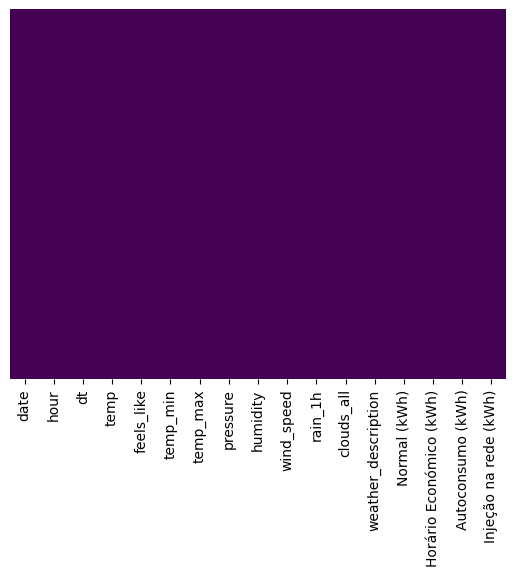

In [35]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [36]:
print(df['Injeção na rede (kWh)'].value_counts().count())

5


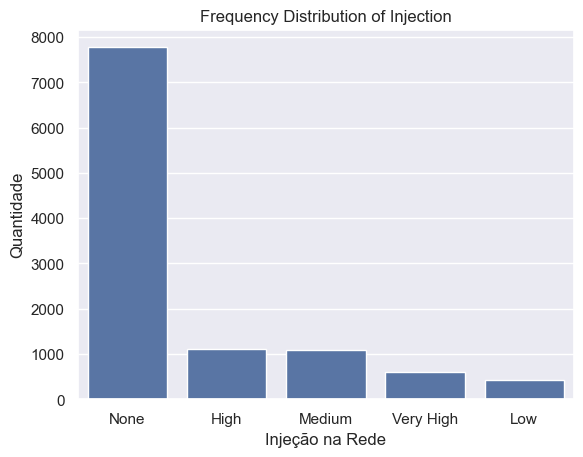

In [37]:
injecao_count = df['Injeção na rede (kWh)'].value_counts()
sns.set(style='darkgrid')
sns.barplot(x=injecao_count.index, y=injecao_count.values)
plt.title('Frequency Distribution of Injection')
plt.ylabel('Quantidade', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()

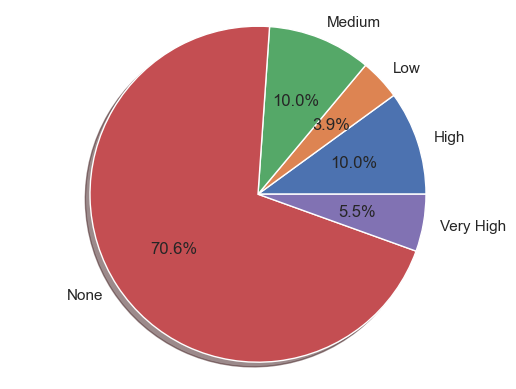

In [38]:
labels = df['Injeção na rede (kWh)'].astype('category').cat.categories.tolist()
counts = df['Injeção na rede (kWh)'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

We have several options how to deal with qualitative data:

#### a) Replace values

In [39]:
df_r1=df.copy()

We need to create a dictionary assigning the string to a numeric value: (Isto é importante!)

None - 0, Low - 1, Medium - 2, High - 3, Very High - 4 (NA PARTE DOS LABELS DÁ DIFERENTE, MAS NÃO EXISTE PROBLEMA NENHUM, VAI DAR AO MESMO)

O mesmo irá ser feito para o weather_description 

In [40]:
replace_map = {'Injeção na rede (kWh)' : {'None': 0, 'Low' : 1, 'Medium': 2, 'High': 3, 'Very High': 4}}
replace_map = {'weather_description' : {'sky is clear': 0, 'overcast clouds' : 1, 'light rain': 2, 'broken clouds': 3, 'scattered clouds': 4, "few clouds": 5, 'moderate rain': 6, 'heavy intensity rain': 7}}

In [41]:
labels = df_r1['Injeção na rede (kWh)'].astype('category').cat.categories.tolist()
replace_map_comp = {'Injeção na rede (kWh)' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print(replace_map_comp)
labels = df_r1['weather_description'].astype('category').cat.categories.tolist()
replace_map_comp2 = {'weather_description' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print(replace_map_comp2)

{'Injeção na rede (kWh)': {'High': 1, 'Low': 2, 'Medium': 3, 'None': 4, 'Very High': 5}}
{'weather_description': {'broken clouds': 1, 'few clouds': 2, 'heavy intensity rain': 3, 'light rain': 4, 'moderate rain': 5, 'overcast clouds': 6, 'scattered clouds': 7, 'sky is clear': 8}}


In [42]:
df_r1.replace(replace_map_comp, inplace=True)
df_r1.replace(replace_map_comp2, inplace=True)

df_r1.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,6,0.0,0.0,0.0,4
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,6,0.0,0.0,0.0,4
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,6,0.0,0.0,0.0,4
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,6,0.0,0.0,0.0,4
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,6,0.0,0.0,0.0,4


In [43]:
print(df_r1['Injeção na rede (kWh)'].dtypes)
print(df_r1['weather_description'].dtypes)

int64
int64


#### b) Label-Encoding

In [44]:
df_r2=df.copy()

In [45]:
print(df_r2.dtypes)

date                       datetime64[ns]
hour                                int32
dt                                  int64
temp                              float64
feels_like                        float64
temp_min                          float64
temp_max                          float64
pressure                            int64
humidity                            int64
wind_speed                        float64
rain_1h                           float64
clouds_all                          int64
weather_description                object
Normal (kWh)                      float64
Horário Económico (kWh)           float64
Autoconsumo (kWh)                 float64
Injeção na rede (kWh)              object
dtype: object


In [46]:
df_r2['None']= np.where(df_r2['Injeção na rede (kWh)'].str.contains('None'), 1, 0)
df_r2.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),None
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,overcast clouds,0.0,0.0,0.0,None,1
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,overcast clouds,0.0,0.0,0.0,None,1
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,overcast clouds,0.0,0.0,0.0,None,1
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,overcast clouds,0.0,0.0,0.0,None,1
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,overcast clouds,0.0,0.0,0.0,None,1


In [47]:
df_r2_skl = df.copy()
df_r22=df.copy()

from sklearn.preprocessing import LabelEncoder


lb_make = LabelEncoder()
df_r2_skl['Código de Injeção'] = lb_make.fit_transform(df_r22['Injeção na rede (kWh)'])

df_r2_skl.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),Código de Injeção
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,overcast clouds,0.0,0.0,0.0,None,3
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,overcast clouds,0.0,0.0,0.0,None,3
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,overcast clouds,0.0,0.0,0.0,None,3
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,overcast clouds,0.0,0.0,0.0,None,3
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,overcast clouds,0.0,0.0,0.0,None,3


In [48]:
value_counts = df_r2_skl['Código de Injeção'].value_counts(dropna=False)
print(value_counts)

Código de Injeção
3    7777
0    1103
2    1098
4     606
1     432
Name: count, dtype: int64


Criamos uma coluna nova, Código de Injeção, with the labels assigned to feature Injeção na Rede (kWh). The numeric values were assigned randomly, being the crescent order not apllicable to the meaning of the qualifying words. (não me apeteceu traduzir tudo)

#### c) One-Hot encoding

This alternative uses LabelBinarizer of sklearn and creates a matrix with bits regarding each label.

In [49]:
df_r3 = df.copy()

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(df_r3['Injeção na rede (kWh)'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

lb_results_df.head()

,High,Low,Medium,None,Very High
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [50]:
result_df = pd.concat([df_r3, lb_results_df], axis=1)

In [51]:
result_df.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,...,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),High,Low,Medium,None,Very High
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,...,overcast clouds,0.0,0.0,0.0,None,0,0,0,1,0
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,...,overcast clouds,0.0,0.0,0.0,None,0,0,0,1,0
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,...,overcast clouds,0.0,0.0,0.0,None,0,0,0,1,0
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,...,overcast clouds,0.0,0.0,0.0,None,0,0,0,1,0
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,...,overcast clouds,0.0,0.0,0.0,None,0,0,0,1,0


#### d) Binary Encoding

Similar to the previous technique, it creates a matrix of the status of the values, but this time with binary values. See the comparison between techniques below:

Fazer tabelas aqui é top xuxa

|   Level   | "Decimal encoding" | Binary encoding | One-Hot encoding |
| :-------: | :----------------: | :-------------: | :--------------: |
| None      |         0          |       000       |      000001      |
| Low       |         1          |       001       |      000010      |
| Medium    |         2          |       010       |      000100      |
| High      |         3          |       011       |      001000      |
| Very High |         4          |       100       |      010000      |

In [52]:
df_r4 = df.copy()

import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Injeção na rede (kWh)'])
df_binary = encoder.fit_transform(df_r4)

df_binary.head()

C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
C:\Users\ferna\miniconda3\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)_0,Injeção na rede (kWh)_1,Injeção na rede (kWh)_2
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,overcast clouds,0.0,0.0,0.0,0,0,1
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,overcast clouds,0.0,0.0,0.0,0,0,1
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,overcast clouds,0.0,0.0,0.0,0,0,1
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,overcast clouds,0.0,0.0,0.0,0,0,1
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,overcast clouds,0.0,0.0,0.0,0,0,1


(Havia mais, mas não é necessário)

### Handling Dates

In [53]:
df_r1dt = df_r1.copy()

In [54]:
df_r1dt['date'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: date, dtype: datetime64[ns]

We are going to convert the dates from <em>object</em> to <em>datetime</em>, specifying the format we want: (esta parte to datetime não era preciso, pois já está em datetime, é só para lembrar num caso que não tenhamos em datetime)

In [55]:
df_r1dt['date'] = pd.to_datetime(df_r1dt['date'], format = '%Y-%m-%d', errors='coerce')

In [56]:
assert df_r1dt['date'].isnull().sum() == 0, 'missing record rate'

In [57]:
df_r1dt['date'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: date, dtype: datetime64[ns]

We can extract parts of the date and create newm columns with that:

In [58]:
df_r1dt['date_year'] = df_r1dt['date'].dt.year
df_r1dt['date_month'] = df_r1dt['date'].dt.month
df_r1dt['date_day'] = df_r1dt['date'].dt.day

In [59]:
df_r1dt.head()

,date,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),date_year,date_month,date_day
0,2021-09-29,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,6,0.0,0.0,0.0,4,2021,9,29
1,2021-09-29,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,6,0.0,0.0,0.0,4,2021,9,29
2,2021-09-29,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,6,0.0,0.0,0.0,4,2021,9,29
3,2021-09-29,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,6,0.0,0.0,0.0,4,2021,9,29
4,2021-09-29,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,6,0.0,0.0,0.0,4,2021,9,29


In [60]:
df_r1dt.nunique()

date                         459
hour                          24
dt                         11016
temp                        2382
feels_like                  2670
temp_min                     481
temp_max                     545
pressure                      41
humidity                      82
wind_speed                   771
rain_1h                      368
clouds_all                   101
weather_description            8
Normal (kWh)                1282
Horário Económico (kWh)      851
Autoconsumo (kWh)            752
Injeção na rede (kWh)          5
date_year                      2
date_month                    12
date_day                      31
dtype: int64

In [61]:
df_r1dt.drop('date',axis=1,inplace=True)

In [62]:
df_r1dt.head()

,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),date_year,date_month,date_day
0,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.0,87,6,0.0,0.0,0.0,4,2021,9,29
1,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.0,91,6,0.0,0.0,0.0,4,2021,9,29
2,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.0,93,6,0.0,0.0,0.0,4,2021,9,29
3,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.0,95,6,0.0,0.0,0.0,4,2021,9,29
4,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.0,93,6,0.0,0.0,0.0,4,2021,9,29


## Train Test Split

Split the data into a training set and a testing set.

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X = df_r1dt.drop(['Injeção na rede (kWh)'],axis=1)
y = df_r1dt['Injeção na rede (kWh)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2022)

In [65]:
X

,hour,dt,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),date_year,date_month,date_day
0,0,1632873600,13.97,13.54,11.45,14.04,1027,81,1.96,0.00,87,6,0.000,0.000,0.0,2021,9,29
1,1,1632877200,13.48,13.02,13.43,13.90,1028,82,1.83,0.00,91,6,0.000,0.000,0.0,2021,9,29
2,2,1632880800,12.93,12.47,12.72,13.43,1027,84,1.96,0.00,93,6,0.000,0.000,0.0,2021,9,29
3,3,1632884400,12.61,12.15,10.34,12.93,1027,85,1.85,0.00,95,6,0.000,0.000,0.0,2021,9,29
4,4,1632888000,12.61,12.17,9.79,12.93,1027,86,1.83,0.00,93,6,0.000,0.000,0.0,2021,9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11011,19,1672513200,15.70,15.57,15.57,15.72,1018,86,5.56,3.58,100,5,1.693,0.000,0.0,2022,12,31
11012,20,1672516800,15.55,15.43,12.72,15.70,1018,87,4.47,4.20,100,3,1.327,0.000,0.0,2022,12,31
11013,21,1672520400,13.45,13.28,12.23,13.99,1019,93,3.29,4.23,100,3,0.757,0.000,0.0,2022,12,31
11014,22,1672524000,12.93,12.73,12.23,13.43,1019,94,1.49,3.90,100,5,0.000,0.675,0.0,2022,12,31


In [68]:
y

0        4
1        4
2        4
3        4
4        4
        ..
11011    4
11012    4
11013    4
11014    4
11015    4
Name: Injeção na rede (kWh), Length: 11016, dtype: int64

# Train a Model

Now it's time to train a Decision Tree Classifier. 

**Call the DecisionTreeClassifier() model from sklearn and fit the model to the training data.**

In [69]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [70]:
dt_model = DecisionTreeClassifier(random_state=2022)

In [71]:
svc_model = SVC(random_state=2022)

In [72]:
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=2022)

In [73]:
svc_model.fit(X_train,y_train)

SVC(random_state=2022)

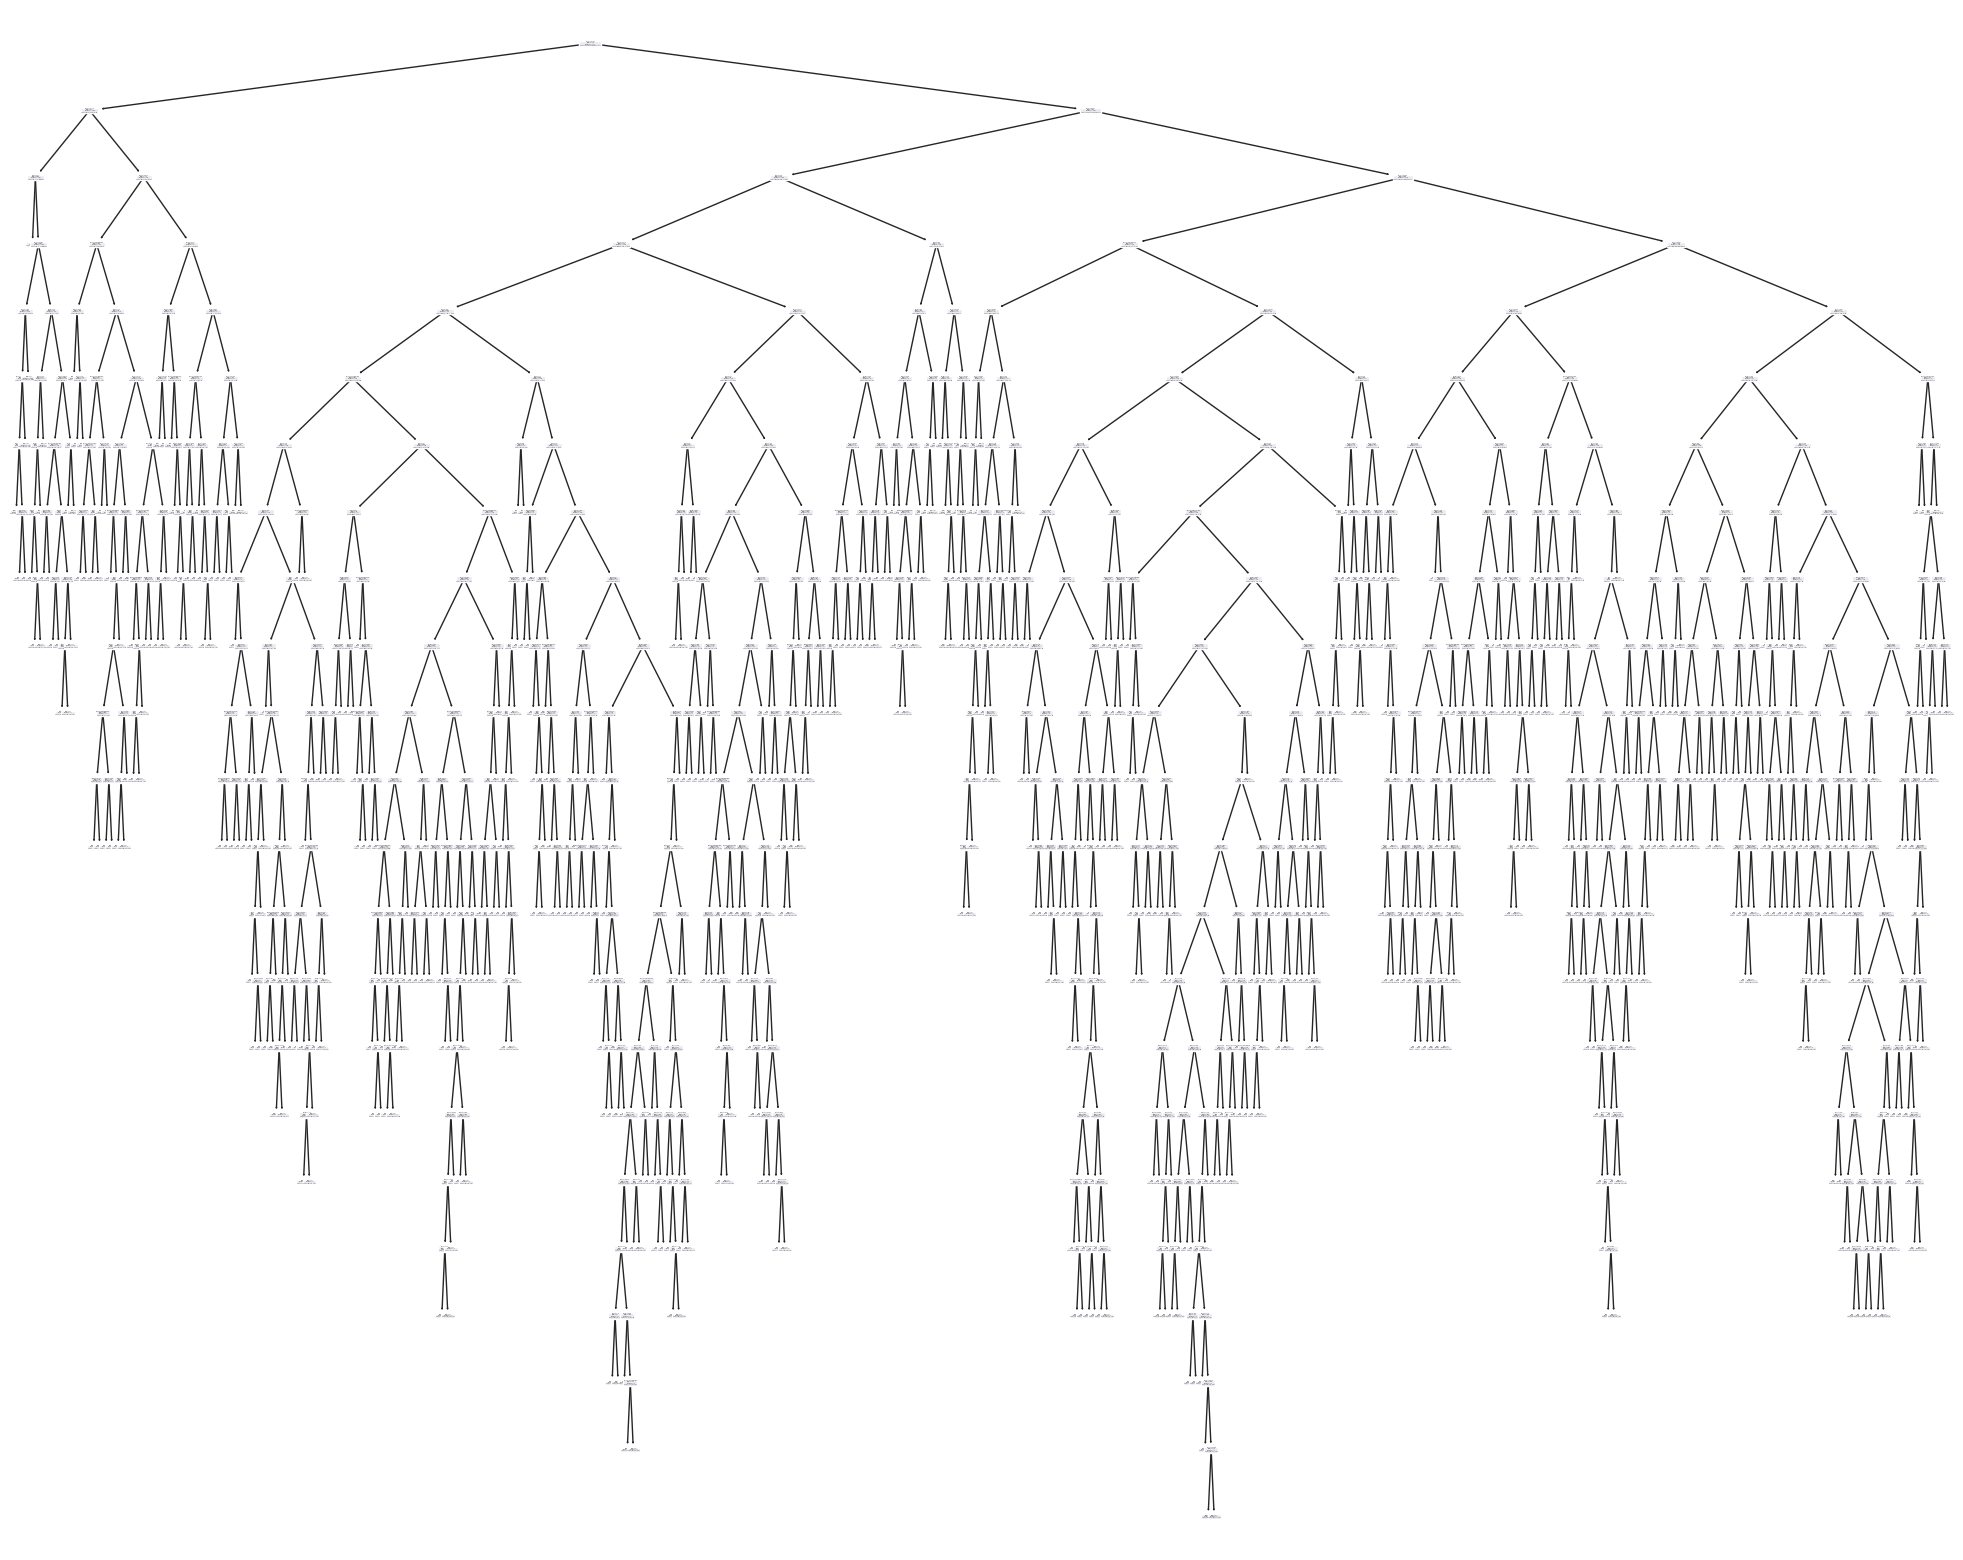

In [64]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(dt_model)
plt.show()

fig.savefig("dt_plot.png")

In [65]:
text_representation = tree.export_text(dt_model)
print(text_representation)

with open("dt_text.log", "w") as fout:
    fout.write(text_representation)

|--- feature_14 <= 0.17
|   |--- feature_14 <= 0.12
|   |   |--- feature_8 <= 0.07
|   |   |   |--- class: 2
|   |   |--- feature_8 >  0.07
|   |   |   |--- feature_14 <= 0.08
|   |   |   |   |--- feature_4 <= 4.75
|   |   |   |   |   |--- feature_1 <= 1636604992.00
|   |   |   |   |   |   |--- feature_8 <= 2.12
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- feature_8 >  2.12
|   |   |   |   |   |   |   |--- feature_2 <= 8.50
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- feature_2 >  8.50
|   |   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- feature_1 >  1636604992.00
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |--- feature_4 >  4.75
|   |   |   |   |   |--- class: 4
|   |   |   |--- feature_14 >  0.08
|   |   |   |   |--- feature_10 <= 7.50
|   |   |   |   |   |--- feature_0 <= 12.00
|   |   |   |   |   |   |--- feature_13 <= 0.48
|   |   |   |   |   |   |   |--- feature_2 <= 5.23
|   |   |   |   |   |

### Model Evaluation

Now let's get predictions from the model and create a confusion matrix and a classification report.

In [74]:
predictions = dt_model.predict(X_test)

In [75]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [76]:
print("%0.2f accuracy" % (accuracy_score(y_test, predictions)))

0.85 accuracy


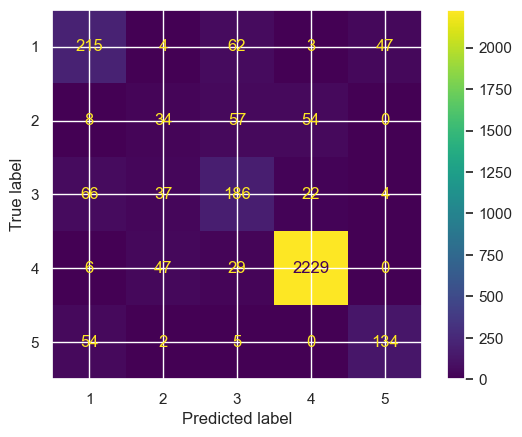

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test,predictions)
plt.show()

#### Grid_Search (Isto é para SVC, o qual não é o melhor nesta ocasião) NÃO CORRER ESTA PARTE, SÓ CORRER A PARTIR DO DECISION TREE CLASSIFIER AND PRUNING

In [70]:
param_grid = {'C' : [0.1, 1, 10, 100, 1000], 'gamma' : [1, 0.1, 0.001, 0.0001], 'kernel': ['rbf']}

In [71]:
from sklearn.model_selection import GridSearchCV

##### Train a model with GridSearchCV

In [72]:
grid = GridSearchCV(SVC(random_state=2021), param_grid, refit=True, verbose=3)

In [ ]:
grid.fit(X_train, y_train)

### Decision Tree Classifier and Pruning

#### GridSearch

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
print(dt_model.get_depth())
print(dt_model.get_n_leaves())

22
652


In [80]:
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth' : [1,2,3,4,5,6,7,8,9,10]}
estimator_dt = DecisionTreeClassifier(random_state=2022)
grid_dt = GridSearchCV(estimator_dt, param_grid_dt, refit=True, verbose=2)

In [82]:
grid_dt.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=1; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=2; total time=   0.0s
[CV] END ........................criterion=gini, max_depth=3; total time=   0.0s
[CV] END ........................criterion=gini

GridSearchCV(estimator=DecisionTreeClassifier(random_state=2022),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=2)

In [84]:
grid_dt_score = grid_dt.score(X_test, y_test)
grid_dt_predictions = grid_dt.predict(X_test)
print(classification_report(y_test,grid_dt_predictions))

              precision    recall  f1-score   support

           1       0.59      0.73      0.65       331
           2       0.44      0.25      0.32       153
           3       0.57      0.64      0.60       315
           4       0.97      0.97      0.97      2311
           5       0.77      0.56      0.65       195

    accuracy                           0.86      3305
   macro avg       0.67      0.63      0.64      3305
weighted avg       0.86      0.86      0.86      3305



In [297]:
print('Accuracy: %.3f%%' % (grid_dt_score * 100))

Accuracy: 85.900%


In [86]:
results = {'DTGridSearchCV': grid_dt_score}

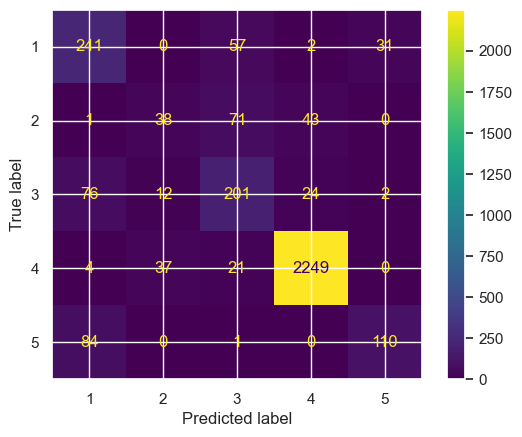

In [87]:
ConfusionMatrixDisplay.from_predictions(y_test, grid_dt_predictions)
plt.show()

##### Best Depth Tree

In [88]:
max_depth = dt_model.get_depth()
max_depth

22

In [89]:
param_grid = {'max_depth': [max_depth for max_depth in range(1, max_depth + 1)]}

In [90]:
estimator = DecisionTreeClassifier(random_state=28)

In [91]:
max_depth_grid_search = GridSearchCV(estimator, param_grid)

In [92]:
max_depth_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=28),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21,
                                       22]})

In [93]:
max_depth_grid_search.best_params_

{'max_depth': 9}

In [94]:
max_depth_tree = max_depth_grid_search.best_estimator_
print(max_depth_tree)

DecisionTreeClassifier(max_depth=9, random_state=28)


In [95]:
best_max_depth = max_depth_tree.get_depth()
print(best_max_depth)

9


In [96]:
max_depth_grid_search_score = max_depth_grid_search.score(X_test, y_test)
max_depth_grid_search_predictions = max_depth_grid_search.predict(X_test)
print(classification_report(y_test,max_depth_grid_search_predictions))

              precision    recall  f1-score   support

           1       0.64      0.68      0.66       331
           2       0.32      0.17      0.22       153
           3       0.54      0.68      0.60       315
           4       0.98      0.96      0.97      2311
           5       0.70      0.72      0.71       195

    accuracy                           0.86      3305
   macro avg       0.64      0.64      0.63      3305
weighted avg       0.85      0.86      0.85      3305



In [298]:
print('Accuracy: %.3f%%' % (max_depth_grid_search_score * 100))

Accuracy: 85.628%


In [98]:
results['Max_Depth'] = max_depth_grid_search_score

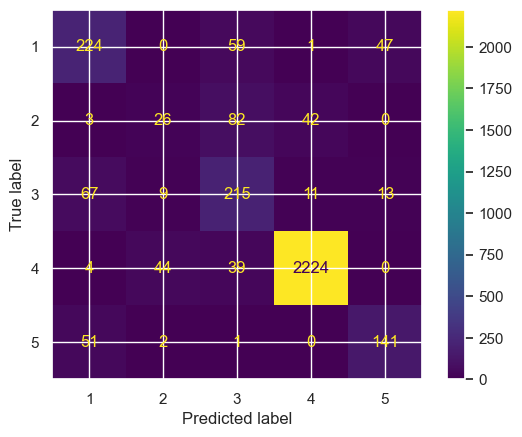

In [99]:
ConfusionMatrixDisplay.from_predictions(y_test, max_depth_grid_search_predictions)
plt.show()

#### Cost Complexity Pruning

In [100]:
ccp_alphas = dt_model.cost_complexity_pruning_path(X_train, y_train)["ccp_alphas"]
ccp_alphas

array([0.00000000e+00, 1.08070721e-04, 1.11158456e-04, 1.13474258e-04,
       1.13474258e-04, 1.13474258e-04, 1.15275436e-04, 1.15275436e-04,
       1.15275436e-04, 1.16716379e-04, 1.17895333e-04, 1.17895333e-04,
       1.17895333e-04, 1.18407921e-04, 1.20421661e-04, 1.21039208e-04,
       1.21039208e-04, 1.21579562e-04, 1.21903774e-04, 1.22056344e-04,
       1.22203047e-04, 1.22480151e-04, 1.23509396e-04, 1.24281330e-04,
       1.24281330e-04, 1.24696986e-04, 1.25053263e-04, 1.25362037e-04,
       1.25501483e-04, 1.25870605e-04, 1.25870605e-04, 1.25979584e-04,
       1.26272106e-04, 1.27253275e-04, 1.28063805e-04, 1.29493477e-04,
       1.29631343e-04, 1.29684866e-04, 1.29684866e-04, 1.29684866e-04,
       1.29684866e-04, 1.29684866e-04, 1.29684866e-04, 1.29684866e-04,
       1.29684866e-04, 1.29684866e-04, 1.29684866e-04, 1.29684866e-04,
       1.29684866e-04, 1.29684866e-04, 1.29684866e-04, 1.29684866e-04,
       1.29684866e-04, 1.29684866e-04, 1.29684866e-04, 1.29684866e-04,
      

In [101]:
estimator.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [102]:
param_grid = {'ccp_alpha': [alpha for alpha in ccp_alphas]}

In [103]:
estimator_dt = DecisionTreeClassifier(random_state=28)
ccp_alpha_grid_search = GridSearchCV(estimator_dt, param_grid)

In [104]:
ccp_alpha_grid_search.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=28),
             param_grid={'ccp_alpha': [0.0, 0.00010807072148013661,
                                       0.0001111584563795691,
                                       0.00011347425755414344,
                                       0.00011347425755414344,
                                       0.00011347425755414344,
                                       0.00011527543624547904,
                                       0.00011527543624547904,
                                       0.00011527543624547904,
                                       0.00011671637919854756,
                                       0.0001178953325237854,
                                       0.0001178953325237854,
                                       0.000117...
                                       0.00012042166107786653,
                                       0.00012103920805775302,
                                       0.00012103920805775302,
                                       0.00012157956166515367,
                                       0.00012190377382959406,
                                       0.00012205634425991902,
                                       0.00012220304659676983,
                                       0.0001224801510108215,
                                       0.00012350939597729902,
                                       0.00012428132970215716,
                                       0.00012428132970215716,
                                       0.0001246969863232346,
                                       0.0001250532634270152,
                                       0.0001253620369169584,
                                       0.0001255014830091908,
                                       0.00012587060501804138, ...]})

In [105]:
ccp_alpha_grid_search.best_params_

{'ccp_alpha': 0.0007396704039487078}

In [106]:
best_ccp_alpha_tree = ccp_alpha_grid_search.best_estimator_
print(best_ccp_alpha_tree)

DecisionTreeClassifier(ccp_alpha=0.0007396704039487078, random_state=28)


In [107]:
ccp_alpha_grid_search_score = ccp_alpha_grid_search.score(X_test, y_test)
ccp_alpha_grid_search_predictions = ccp_alpha_grid_search.predict(X_test)
print(classification_report(y_test,ccp_alpha_grid_search_predictions))

              precision    recall  f1-score   support

           1       0.59      0.74      0.66       331
           2       0.50      0.08      0.15       153
           3       0.57      0.64      0.60       315
           4       0.96      0.98      0.97      2311
           5       0.76      0.65      0.70       195

    accuracy                           0.86      3305
   macro avg       0.68      0.62      0.62      3305
weighted avg       0.86      0.86      0.85      3305



In [299]:
print('Accuracy: %.3f%%' % (ccp_alpha_grid_search_score * 100))

Accuracy: 86.172%


In [109]:
results['ccp_alpha_grid'] = ccp_alpha_grid_search_score

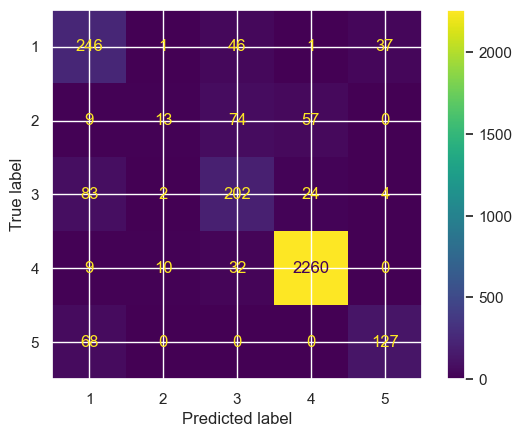

In [110]:
ConfusionMatrixDisplay.from_predictions(y_test, ccp_alpha_grid_search_predictions)
plt.show()

### Bagging (Boostrap Aggregating)

In [111]:
sss = StratifiedShuffleSplit(n_splits = 10, test_size = 30, random_state = 2022)

In [112]:
bg_model = BaggingClassifier(estimator = dt_model, bootstrap= True)

In [113]:
n_estimators = [10, 40, 60, 80, 100, 160]

In [114]:
parameters = {'n_estimators': n_estimators}

In [115]:
grid_bg = GridSearchCV(estimator= bg_model, param_grid= parameters, cv = sss)

In [116]:
grid_bg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=2022, test_size=30,
            train_size=None),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=2022)),
             param_grid={'n_estimators': [10, 40, 60, 80, 100, 160]})

In [119]:
grid_bg_score = grid_bg.score(X_test, y_test)

In [300]:
print("Accuracy: %.3f%%" % (grid_bg_score*100))

Accuracy: 87.262%


In [124]:
grid_bg_predictions = grid_bg.predict(X_test)
print(classification_report(y_test, grid_bg_predictions))

              precision    recall  f1-score   support

           1       0.67      0.70      0.68       331
           2       0.44      0.23      0.30       153
           3       0.59      0.69      0.64       315
           4       0.97      0.98      0.97      2311
           5       0.78      0.73      0.75       195

    accuracy                           0.87      3305
   macro avg       0.69      0.67      0.67      3305
weighted avg       0.87      0.87      0.87      3305



In [125]:
results['Bagg'] = grid_bg_score

### Random Forest

In [226]:
rf_model = RandomForestClassifier(bootstrap= False, max_depth = 13, verbose = 1)

In [227]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


RandomForestClassifier(bootstrap=False, max_depth=13, verbose=1)

In [228]:
rf_score = rf_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [301]:
print("Accuracy: %.3f%%" % (rf_score*100))

Accuracy: 86.808%


In [230]:
rf_predictions = rf_model.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [231]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           1       0.65      0.70      0.68       331
           2       0.46      0.15      0.23       153
           3       0.56      0.72      0.63       315
           4       0.97      0.98      0.97      2311
           5       0.79      0.66      0.72       195

    accuracy                           0.87      3305
   macro avg       0.68      0.64      0.64      3305
weighted avg       0.86      0.87      0.86      3305



In [232]:
results['RF'] = rf_score

### Boosting
#### Gradient Boosting

In [252]:
gbc_model = GradientBoostingClassifier(n_estimators= 100, learning_rate= 1.0, max_depth= 1, random_state= 2024)

In [253]:
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=2024)

In [302]:
gbc_score = gbc_model.score(X_test, y_test)
print("Accuracy: %.3f%%" % (gbc_score*100))

Accuracy: 86.203%


In [255]:
gbc_predictions = gbc_model.predict(X_test)
print(classification_report(y_test, gbc_predictions))

              precision    recall  f1-score   support

           1       0.63      0.71      0.67       331
           2       0.34      0.17      0.23       153
           3       0.59      0.66      0.62       315
           4       0.97      0.97      0.97      2311
           5       0.75      0.68      0.71       195

    accuracy                           0.86      3305
   macro avg       0.65      0.64      0.64      3305
weighted avg       0.86      0.86      0.86      3305



In [256]:
results['GB'] = gbc_score

### XGBoost
##### Este está um pouco modificado quanto aos números (ver y_train_adjusted)
Não vale a pena fazer

In [266]:
xgb_model = XGBClassifier(max_depth = 3, objective= 'req:squarederror')

In [267]:
# Subtrair 1 de cada classe nos seus dados de treinamento
y_train_adjusted = y_train - 1
y_train_adjusted

2750    0
1777    3
2099    3
5460    4
8831    3
       ..
6384    3
4720    2
173     3
1244    3
4989    3
Name: Injeção na rede (kWh), Length: 7711, dtype: int64

In [268]:
xgb_model.fit(X_train, y_train_adjusted)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [269]:
xgb_score = xgb_model.score(X_test, y_test)

In [303]:
print('Accuracy: %.3f%%' % (xgb_score*100))

Accuracy: 2.451%


In [271]:
xbg_predictions = xgb_model.predict(X_test)
print(classification_report(y_test, xbg_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.01      0.00      0.00       331
           2       0.18      0.41      0.25       153
           3       0.01      0.06      0.01       315
           4       0.00      0.00      0.00      2311
           5       0.00      0.00      0.00       195

    accuracy                           0.02      3305
   macro avg       0.03      0.08      0.04      3305
weighted avg       0.01      0.02      0.01      3305



C:\Users\ferna\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ferna\miniconda3\Lib\site-packages\sklearn\metrics\

In [272]:
results['XGB'] =xgb_score

### Stacking

In [273]:
estimators = [("dt", dt_model), ("rf", rf_model)]

In [274]:
st_model = StackingClassifier(estimators=estimators, final_estimator= LogisticRegression())

In [275]:
st_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
C:\Users\ferna\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Plea

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(random_state=2022)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=13,
                                                       verbose=1))],
                   final_estimator=LogisticRegression())

In [276]:
st_score = st_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [304]:
print("Accuraçy: %.3f%%" % (st_score*100))

Accuraçy: 87.171%


In [278]:
st_predictions =st_model.predict(X_test)
print(classification_report(y_test, st_predictions))

              precision    recall  f1-score   support

           1       0.67      0.71      0.69       331
           2       0.41      0.14      0.21       153
           3       0.58      0.71      0.64       315
           4       0.97      0.98      0.97      2311
           5       0.77      0.70      0.74       195

    accuracy                           0.87      3305
   macro avg       0.68      0.65      0.65      3305
weighted avg       0.86      0.87      0.86      3305



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [279]:
results['Stack'] = st_score

### MAX voting

In [280]:
hvt_model = VotingClassifier(estimators = [("dt", dt_model), ("rf", rf_model)],
                             voting = 'hard', weights=[2,2])

In [281]:
hvt_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=2022)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=13,
                                                     verbose=1))],
                 weights=[2, 2])

In [282]:
for model, label in zip([dt_model, rf_model, hvt_model],['dt','rf','Ensemble']):
    hvt_score = cross_val_score(model, X_test, y_test, scoring= 'accuracy', cv = 5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (hvt_score.mean(), hvt_score.std(), label))

Accuracy: 0.83 (+/- 0.01) [dt]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Accuracy: 0.85 (+/- 0.01) [rf]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


Accuracy: 0.84 (+/- 0.01) [Ensemble]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [305]:
hvt_score = hvt_model.score(X_test, y_test)
print("Accuracy: %.3f%%" % (hvt_score*100))

Accuracy: 84.690%


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [284]:
hvt_predictions = hvt_model.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [285]:
print(classification_report(y_test, hvt_predictions))

              precision    recall  f1-score   support

           1       0.57      0.78      0.66       331
           2       0.33      0.32      0.33       153
           3       0.54      0.53      0.54       315
           4       0.98      0.96      0.97      2311
           5       0.80      0.54      0.64       195

    accuracy                           0.85      3305
   macro avg       0.64      0.63      0.63      3305
weighted avg       0.86      0.85      0.85      3305



In [287]:
results['HVotW'] = hvt_score

## Models Accuracy Comparison

<function matplotlib.pyplot.show(close=None, block=None)>

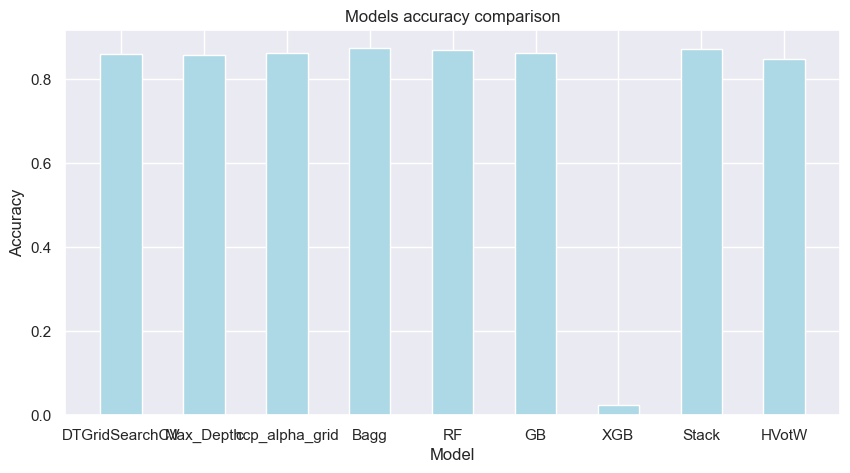

In [306]:
fig = plt.figure(figsize = (10, 5))

mod = list(results.keys())
acc = list(results.values())

plt.bar(mod, acc, color = 'lightblue',
       width= 0.5)

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Models accuracy comparison")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

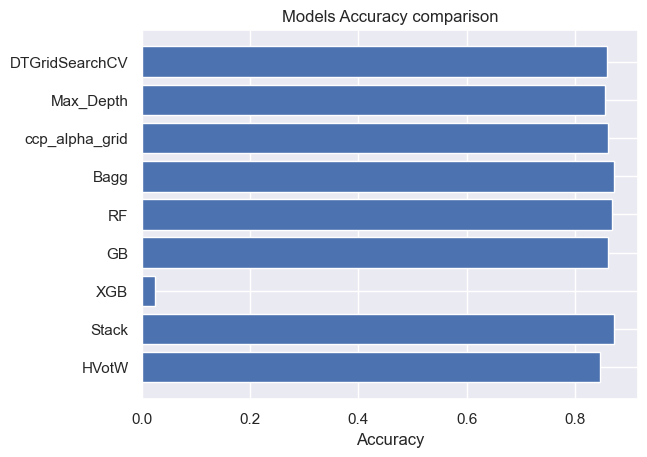

In [307]:
fig, ax = plt.subplots()

y_values = np.arange(len(mod))

ax.barh(y_values, acc, align='center')
ax.set_yticks(y_values, labels = mod)
ax.invert_yaxis()
ax.set_xlabel('Accuracy')
ax.set_title('Models Accuracy comparison')

plt.show

In [308]:
print('Models accuracy comparison')
for key, value in results.items():
    print("%s \t %.3f%%" % (key, value))

Models accuracy comparison
DTGridSearchCV 	 0.859%
Max_Depth 	 0.856%
ccp_alpha_grid 	 0.862%
Bagg 	 0.873%
RF 	 0.868%
GB 	 0.862%
XGB 	 0.025%
Stack 	 0.872%
HVotW 	 0.847%


### Resumindo o que foi feito:

Basicamente dos treinos todos feitos, o tuning (qualquer um) melhorou +-0,2 o que é ótimo (quanto a mais casas décimais não sabemos, daí vamos ter que ir experimentar as 3 submissões dos 3 tunings que dão 0.86 e ver qual o maior accuracy na submissão), agora precisamos de voltar a pôr os dados normais (em None, Low, etc) e pôr no submissions.

Para já isto foi o melhor que consegui, mas tenho mais ideias para usar, nomeadamente aplicar xboost (o xboost nunca chegamos a fazer, mas um gajo inventa e consegue chegar lá) e gradient boosting regressor

##### ATUALIZAÇÃO:
Estão os modelos "todos feitos". Supostamente, segundo outros colegas, o random forest é o que costuma dar melhor resultado. No nosso caso não é, não entendo porquê, mas a nós o melhor que consegui foi do Bagging(Bootstrap Aggregating) aka Bagg, com 0.873. Quanto ao XGB, ele dá erro caso não tenha os valores a começar por 0, na Injeção de Rede. Eu troquei e cagou o modelo todo, não sei se realmente existe alguma forma consistente para que não dê 0.025%.
De resto, tentem então rever tudo e o Random_Forest principalmente por ser o melhor quanto aos outros, e no nosso caso não o ser (weirdly).

### Repor Valores

In [104]:
import joblib

In [110]:
# Save the model to a file
joblib.dump(max_depth_grid_search, 'Max_depth_grid_searchDT.pkl')

['Max_depth_grid_searchDT.pkl']

In [111]:
# Carregue o modelo treinado (substitua 'seu_modelo_arvore_decisao.pkl' pelo caminho correto)
loaded_dt_model = joblib.load('Max_depth_grid_searchDT.pkl')

## Guardar no dummy_submissions

In [33]:
# Passa os valores previstos, que *futuramente* vao estar no dataframe df_energia3, para o dataframe df_submission
df_submission.iloc[:, 1] = df_energia3['Injeção na rede (kWh)'].values
df_submission

,RowId,Result
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN
...,...,...
2251,2252,NaN
2252,2253,NaN
2253,2254,NaN
2254,2255,NaN


In [34]:
# Guardar no ficheiro 'dummy_submission.csv'
df_submission.replace({None: 'None', np.nan: 'None'}, inplace=True)
df_submission.to_csv('./datasets/dummy_submission.csv', index=False)